## 1. Introduction

This work presents a comparison between classical machine learning methods and a neural network built from scratch for binary classification. The goal is to understand how both approaches perform on a real-world physics problem and to identify situations where one method may work better than the other.

Classical machine learning algorithms like logistic regression and support vector machines have been used successfully for many years (Hastie et al., 2009). These methods work well when data has clear patterns and when the number of features is not too large. Neural networks, on the other hand, can learn more complex patterns but need more data and careful training (Goodfellow et al., 2016). By building a neural network from scratch using only NumPy, this analysis aims to show exactly how these models learn and where their strengths come from.

The analysis follows several steps. First, a dataset is selected and explored to understand its properties. Second, two classical ML models are trained with different settings to find what works best. Third, a 3-layer feed-forward neural network is built from scratch, with all calculations done manually. Finally, all models are compared using standard metrics like accuracy, precision, recall, and F1-score. This approach allows for a clear understanding of both the theory and practice of these different methods.

## 2. Dataset Selection and Justification

### 2.1 Choice of Dataset

The MAGIC Gamma Telescope dataset from the UCI Machine Learning Repository serves as the foundation for this analysis. This dataset comes from the MAGIC telescope system, which detects high-energy gamma rays from cosmic sources like supernova remnants and active galactic nuclei.

### 2.2 Scientific Background

When gamma rays from space enter Earth's atmosphere, they create showers of particles that produce brief flashes of light. Ground-based telescopes capture these flashes to study distant cosmic events. However, the telescope also detects similar flashes from hadrons, which are different types of particles. The challenge is to separate true gamma ray signals from hadron backgrounds, which is critical for astronomical observations (Albert et al., 2008).

This problem is formulated as a binary classification task. Each observation must be labeled as either a gamma ray event (signal class) or a hadron event (background class). Success in this task directly impacts the ability of astronomers to detect and study gamma ray sources in the universe.

### 2.3 Dataset Structure

The dataset contains 19,020 observations with 10 numerical features. Each feature describes the shape and properties of the light flash captured by the telescope. The features are:

1. fLength: length of the light pattern in millimeters
2. fWidth: width of the light pattern in millimeters
3. fSize: total brightness measured as photon count
4. fConc: concentration ratio of the brightest pixels
5. fConc1: concentration of the single brightest pixel
6. fAsym: measure of how lopsided the pattern is
7. fM3Long: third moment of the pattern along its length
8. fM3Trans: third moment of the pattern along its width
9. fAlpha: angle of the pattern relative to the source
10. fDist: distance from the center in millimeters

The dataset contains 12,332 gamma ray events and 6,688 hadron events, giving a class distribution of approximately 65% gamma and 35% hadron.

### 2.4 Justification for Dataset Selection

This dataset was selected for several reasons. First, it addresses a genuine scientific problem in astrophysics rather than being an artificial test case. The ability to classify these events accurately has real implications for gamma ray astronomy. Second, the features are based on physical measurements and have clear interpretations, which helps in understanding model behavior. Third, the class imbalance reflects realistic conditions that occur in actual telescope operations. Most classification benchmarks use balanced classes, but real-world problems often have unequal class sizes, making this dataset more representative of practical challenges.

Finally, this dataset is not among the most commonly used benchmarks like iris or Titanic, which have been analyzed extensively. Using a less common dataset ensures that the analysis provides fresh insights rather than repeating well-known results.

**Citation:**  
Bock, R. K. (2007). MAGIC Gamma Telescope Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C52C8B

### 2.5 Relevance to the African Continent

The MAGIC Gamma Telescope dataset and gamma ray astronomy hold particular significance for Africa's growing role in global scientific research and technological development. Several factors make this dataset especially relevant for African researchers and institutions:

**1. H.E.S.S. Telescope in Namibia**  
Africa is home to the High Energy Stereoscopic System (H.E.S.S.), one of the world's leading gamma ray telescope arrays located in the Khomas Highland of Namibia. H.E.S.S. has made groundbreaking discoveries including the detection of gamma rays from the center of our galaxy and numerous supernova remnants. The techniques used in this assignment—distinguishing gamma rays from hadron backgrounds—are directly applicable to data processing pipelines at H.E.S.S. and represent skills needed by African scientists working in astroparticle physics.

**2. Cherenkov Telescope Array (CTA) - South**  
The southern hemisphere site of the next-generation Cherenkov Telescope Array is being constructed near Paranal, Chile, but proposals for additional African sites have been discussed due to the continent's excellent atmospheric conditions and geographical positioning for southern sky observations. Understanding gamma ray classification algorithms positions African researchers to contribute to these international collaborations and potentially host future telescope installations.

**3. Capacity Building in Data Science**  
Africa is experiencing rapid growth in data science and AI education, with institutions like the African Institute for Mathematical Sciences (AIMS) and various university programs training the next generation of data scientists. This dataset provides an excellent case study for teaching machine learning in an African context, using data from problems relevant to African scientific infrastructure. It bridges theoretical machine learning concepts with practical applications in African-led research facilities.

**4. Square Kilometre Array (SKA) Synergies**  
South Africa and several partner African countries are hosting the Square Kilometre Array (SKA), the world's largest radio telescope project. While SKA focuses on radio astronomy rather than gamma rays, the data processing challenges are similar: massive datasets requiring real-time classification, signal extraction from noisy backgrounds, and pattern recognition at scale. Skills developed through gamma ray classification transfer directly to SKA data analysis pipelines, making this assignment relevant training for African researchers who will work on SKA projects.

**5. Scientific Self-Reliance and Innovation**  
By engaging with datasets from African-based telescopes and related scientific instruments, this work contributes to building scientific self-reliance on the continent. Rather than only consuming datasets from institutions in other regions, African researchers can develop expertise in analyzing data from African facilities, creating knowledge that can inform policy, attract investment in science infrastructure, and inspire the next generation of African scientists.

**6. Climate and Atmospheric Science Applications**  
The techniques used for gamma ray classification—separating signal from background noise in atmospheric measurements—have broader applications in African climate science. Africa faces significant climate challenges, and machine learning methods for atmospheric data analysis can be adapted to study phenomena like dust storms, precipitation patterns, and atmospheric pollution, all critical for African environmental monitoring.

This analysis therefore serves dual purposes: it provides hands-on experience with classical and neural network approaches to classification while also connecting to tangible scientific infrastructure and research priorities on the African continent.

## 3. Data Loading and Exploratory Analysis

Before building any models, it is necessary to load the dataset and examine its basic properties. This section explores the data structure, checks for missing values, and looks at how features are distributed across the two classes. Understanding these patterns helps guide decisions about preprocessing and model selection.

The code below loads the dataset directly from the UCI repository and assigns meaningful column names to each feature. After loading, basic statistics are computed to check for any unusual values or data quality issues.

In [7]:
# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for consistent visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set default figure parameters for better display
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [20]:
# Load the MAGIC Gamma Telescope dataset
# Dataset available at: https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data"

column_names = [
    'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 
    'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'
]

df = pd.read_csv(url, names=column_names)

print("Dataset loaded successfully.")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset loaded successfully.
Dataset shape: (19020, 11)

First few rows:


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [9]:
# Basic statistical summary
print("Dataset Information:")
print(df.info())
print("\nStatistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB
None

Statistical Summary:


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


In [10]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Examine class distribution
print("\nClass distribution:")
print(df['class'].value_counts())
print("\nClass proportions:")
print(df['class'].value_counts(normalize=True))

Missing values per column:
fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64

Class distribution:
class
g    12332
h     6688
Name: count, dtype: int64

Class proportions:
class
g    0.64837
h    0.35163
Name: proportion, dtype: float64


### 3.1 Data Visualization

Visual analysis of the feature distributions provides insight into which features might be most useful for classification. The plots below show how each feature is distributed for gamma ray events compared to hadron events. Features that show clear separation between the two classes are likely to be strong predictors in the classification models.

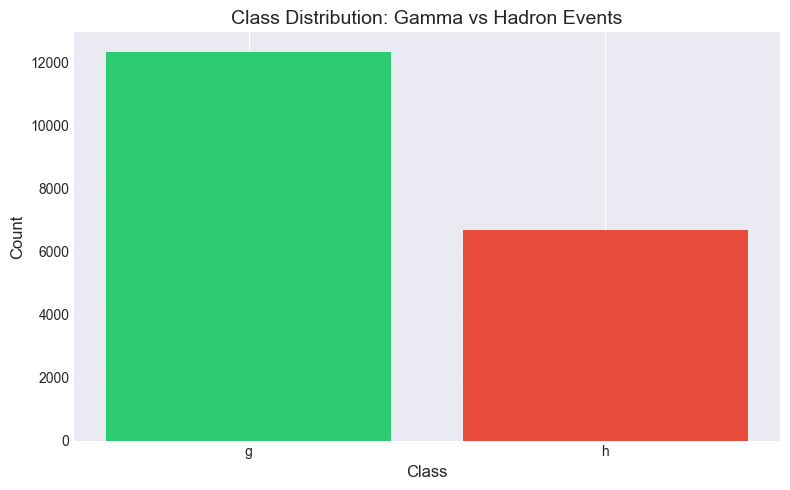

In [11]:
# Visualize class distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
class_counts = df['class'].value_counts()
ax.bar(class_counts.index, class_counts.values, color=['#2ecc71', '#e74c3c'])
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Class Distribution: Gamma vs Hadron Events', fontsize=14)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

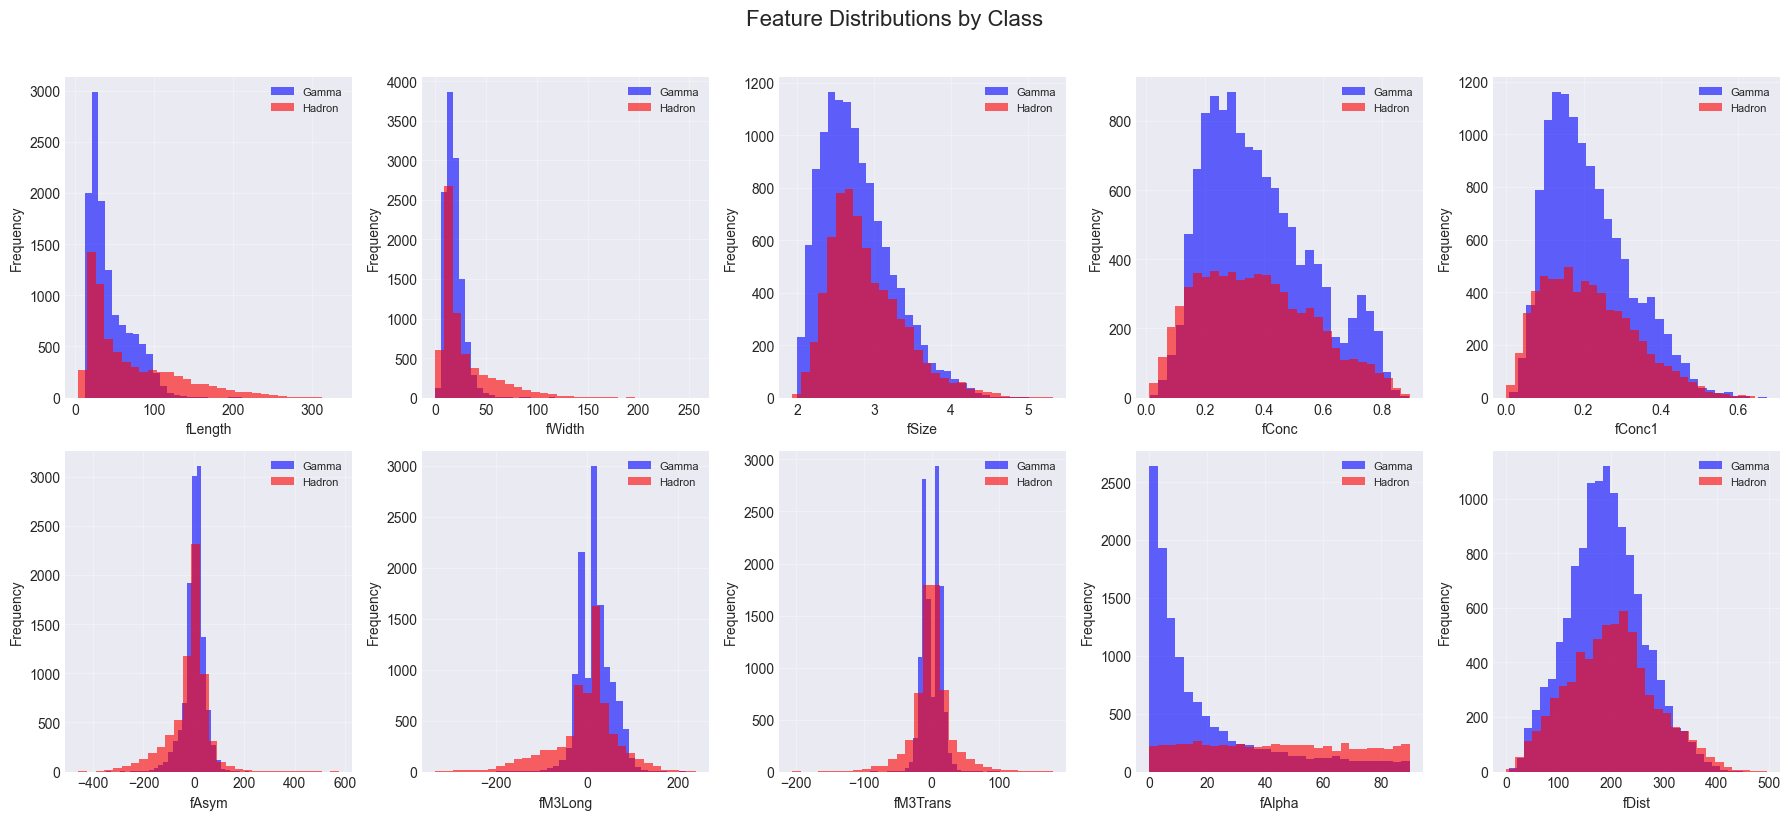

In [12]:
# Feature distribution analysis
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()

for idx, col in enumerate(df.columns[:-1]):
    axes[idx].hist(df[df['class'] == 'g'][col], bins=30, alpha=0.6, label='Gamma', color='blue')
    axes[idx].hist(df[df['class'] == 'h'][col], bins=30, alpha=0.6, label='Hadron', color='red')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.suptitle('Feature Distributions by Class', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 3.2 Interpretation of Feature Distributions


The histograms reveal several important patterns in the data. Features such as fLength, fWidth, fSize, and fConc show different distributions for gamma rays compared to hadrons. This suggests that these features carry information that can help separate the two classes. However, the distributions still show considerable overlap, which means that no single feature can perfectly separate gamma rays from hadrons on its own.Given these patterns, it is expected that classification models will benefit from using all features together rather than relying on any single measurement. The overlap in distributions also suggests that perfect classification is unlikely, and some level of error should be expected even with good models.


The fAlpha feature shows particularly strong separation between the two classes. This observation aligns with findings in the astrophysics literature, where the alpha parameter has been identified as one of the most powerful features for gamma ray identification (Albert et al., 2008). The physical reason for this is that gamma ray showers tend to point back toward their source, creating a characteristic angular signature that differs from hadron showers.

### 3.3 Correlation Analysis

Understanding how features relate to each other is important for several reasons. Highly correlated features may provide redundant information, while features that show strong correlation with the target class are likely to be good predictors. A correlation matrix visualizes these relationships and helps identify patterns that might not be obvious from histograms alone.

The heatmap below shows Pearson correlation coefficients between all pairs of features. Values close to 1 or -1 indicate strong relationships, while values near 0 suggest independence. This analysis helps determine whether feature selection or dimensionality reduction might be needed before training models.

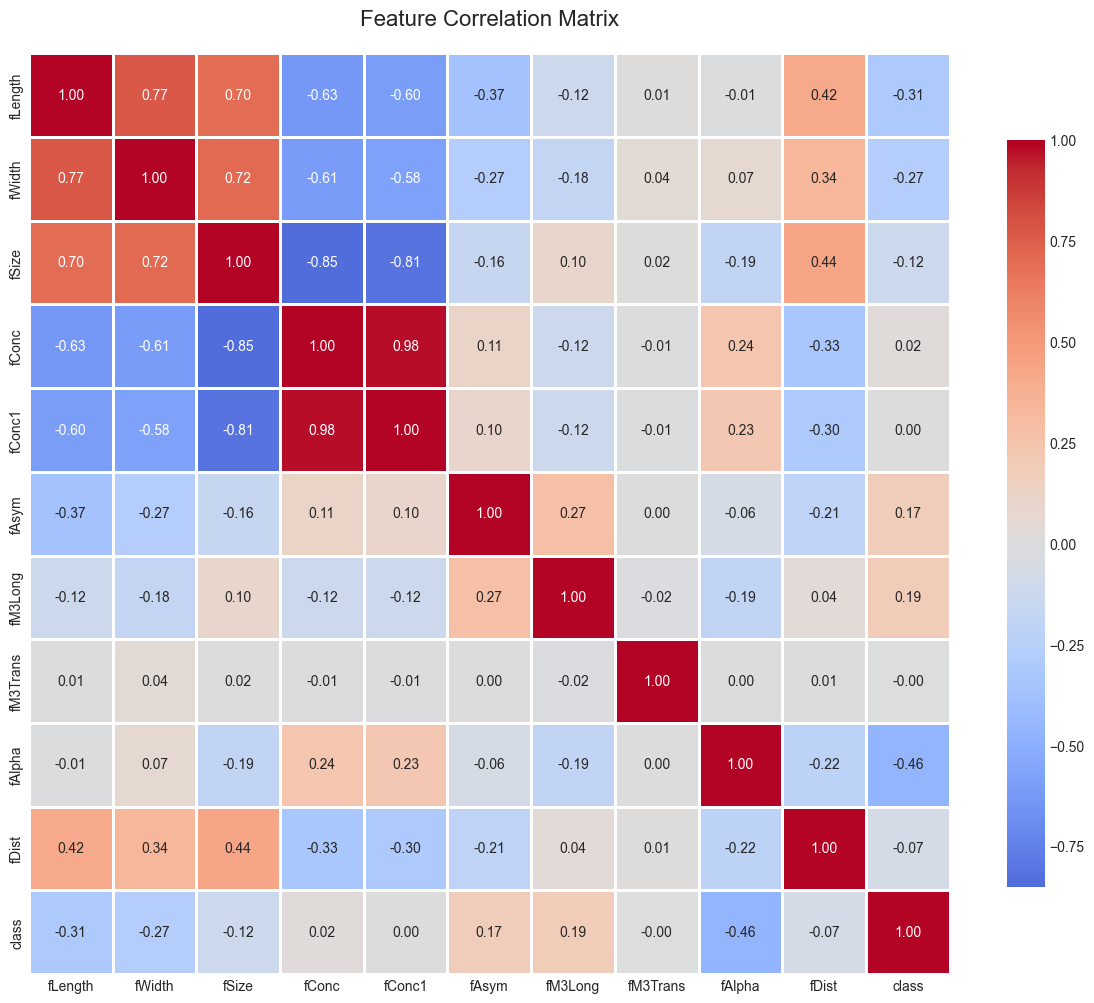

Correlation with target class (gamma=1, hadron=0):
fM3Long     0.193409
fAsym       0.173587
fConc       0.024615
fConc1      0.004797
fM3Trans   -0.003837
fDist      -0.065203
fSize      -0.117795
fWidth     -0.265596
fLength    -0.307572
fAlpha     -0.460979
Name: class, dtype: float64


In [15]:
# Create correlation matrix
# First encode the target variable numerically for correlation analysis
df_numeric = df.copy()
df_numeric['class'] = df_numeric['class'].map({'g': 1, 'h': 0})

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Display correlations with target variable
print("Correlation with target class (gamma=1, hadron=0):")
print(correlation_matrix['class'].sort_values(ascending=False).drop('class'))

### 3.4 Feature Pair Plots for Key Variables

To better understand the separability between gamma and hadron events, pair plots for a subset of the most important features are examined. These scatter plots show the relationship between pairs of features while color-coding points by class. Clear separation in these plots suggests that models should be able to learn good decision boundaries.

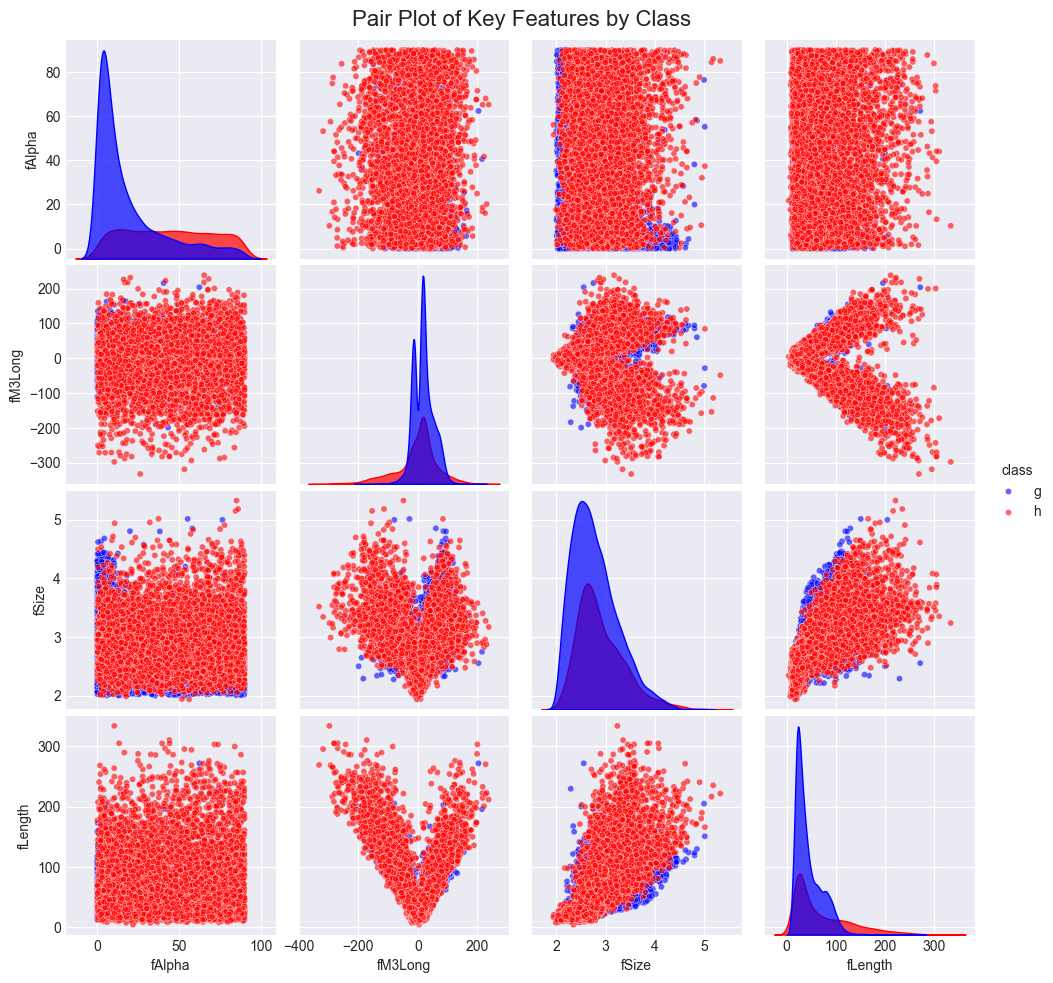

In [18]:
# Select key features for pair plot based on correlation analysis
key_features = ['fAlpha', 'fM3Long', 'fSize', 'fLength', 'class']
df_subset = df[key_features].copy()

# Create pair plot
pairplot = sns.pairplot(df_subset, hue='class', palette={'g': 'blue', 'h': 'red'}, 
                        diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20}, 
                        diag_kws={'alpha': 0.7})
pairplot.fig.subplots_adjust(top=0.95)
pairplot.fig.suptitle('Pair Plot of Key Features by Class', y=0.98, fontsize=16)
plt.show()

## 4. Data Preprocessing

Before training any models, the data must be preprocessed properly. This section handles three critical steps that are standard in machine learning workflows. First, the categorical class labels are converted to numerical values that models can process. Second, the data is split into training and testing sets to allow for unbiased evaluation. Third, features are scaled to have similar ranges, which is important for many algorithms that are sensitive to feature magnitudes (Hastie et al., 2009).

The choice of an 80-20 train-test split is standard practice and provides enough data for training while reserving sufficient samples for testing. Feature scaling using standardization transforms each feature to have zero mean and unit variance, which helps gradient-based optimization converge faster and prevents features with larger numerical ranges from dominating the learning process.

In [16]:
# Separate features and target
X = df.drop('class', axis=1).values
y = df['class'].map({'g': 1, 'h': 0}).values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nClass distribution in target:")
print(f"Gamma (1): {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")
print(f"Hadron (0): {np.sum(y == 0)} ({np.mean(y == 0)*100:.2f}%)")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling completed.")
print(f"Mean of scaled training features: {X_train_scaled.mean(axis=0)}")
print(f"Std of scaled training features: {X_train_scaled.std(axis=0)}")

Feature matrix shape: (19020, 10)
Target vector shape: (19020,)

Class distribution in target:
Gamma (1): 12332 (64.84%)
Hadron (0): 6688 (35.16%)

Training set size: 15216
Testing set size: 3804

Feature scaling completed.
Mean of scaled training features: [-5.65064557e-15  3.79904806e-15 -4.61013252e-15 -7.11456977e-15
 -1.03708555e-15 -8.56854895e-17 -1.15373339e-15  1.29511427e-17
  3.45385451e-15  2.35574682e-14]
Std of scaled training features: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 4.1 Visualization of Scaled Features

After standardization, all features should have similar scales. The box plots below show the distribution of scaled features in the training set. Features centered around zero with similar spread indicate successful scaling, which ensures that no single feature dominates the learning process due to its magnitude.

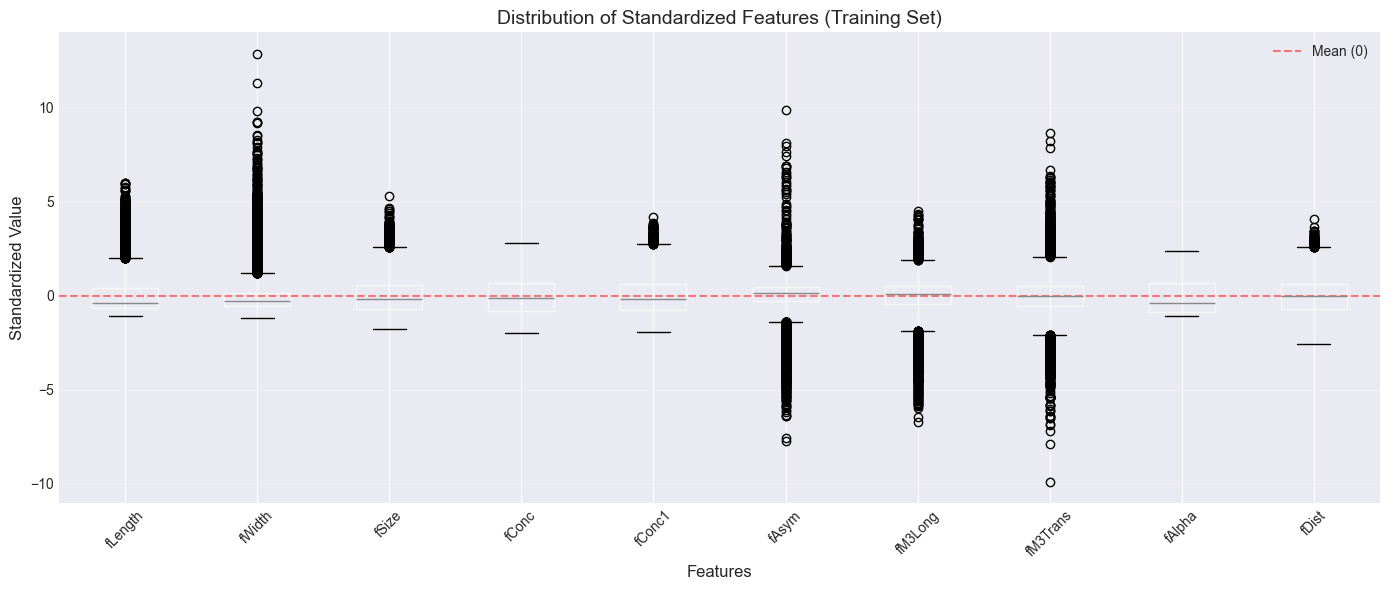

In [17]:
# Visualize scaled features
fig, ax = plt.subplots(figsize=(14, 6))
scaled_df = pd.DataFrame(X_train_scaled, columns=df.columns[:-1])
scaled_df.boxplot(ax=ax)
ax.set_title('Distribution of Standardized Features (Training Set)', fontsize=14)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Standardized Value', fontsize=12)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Mean (0)')
ax.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Summary of Data Analysis

The exploratory analysis of the MAGIC Gamma Telescope dataset reveals several important characteristics that will influence model selection and evaluation strategies. The dataset contains 19,020 observations across 10 numerical features, with no missing values, ensuring data quality for model training.

The class distribution shows a moderate imbalance, with gamma ray events accounting for 65% of observations and hadron events representing 35%. This imbalance has important implications for model evaluation. Using accuracy alone would be misleading, as a naive classifier that always predicts gamma rays would achieve 65% accuracy without learning any meaningful patterns. Therefore, precision, recall, and F1-score become essential metrics for assessing model performance on this dataset.

Feature distribution analysis reveals that certain features show stronger discriminative power than others. The fAlpha parameter exhibits particularly clear separation between gamma and hadron events, consistent with astrophysics literature that identifies the alpha angle as a key discriminator in Cherenkov telescope analysis. Other features such as fM3Long, fSize, and fConc also show different distributions across classes, though with more overlap. The presence of overlap across all features suggests that no single feature can perfectly separate the classes, motivating the use of machine learning models that can combine information from multiple features.

Correlation analysis shows moderate relationships among features, with some expected physical dependencies between measurements like fLength and fM3Long. The target variable shows the strongest correlations with fAlpha, fM3Long, and fSize, confirming that these features carry the most predictive information. The absence of extremely high correlations between feature pairs indicates that multicollinearity should not be a major concern, and all features contribute unique information to the classification task.

The pair plots of key features demonstrate that combinations of features provide better class separation than individual features alone. Several feature pairs show regions where one class clearly dominates, suggesting that linear and nonlinear decision boundaries should both be explored during model training. The visual patterns confirm that the data is learnable, with clear structure that models can exploit.

After preprocessing through train-test splitting and standardization, the data is ready for model training. The stratified 80-20 split maintains the original class distribution in both sets, ensuring representative evaluation. Feature standardization places all variables on comparable scales, which is critical for algorithms that are sensitive to feature magnitudes, such as support vector machines and neural networks. The standardization also accelerates convergence in gradient-based optimization methods.

These findings establish realistic expectations for model performance and guide the choice of algorithms and evaluation metrics in the following sections.

## 6. Classical Machine Learning Models

This section implements two classical machine learning algorithms for the gamma-hadron classification task: Logistic Regression and Support Vector Machines. These algorithms represent different approaches to binary classification and provide baseline performance metrics for comparison with the neural network implementation in the following section.

Logistic Regression is chosen as a linear model that estimates the probability of class membership through a logistic function. Despite its simplicity, logistic regression often performs well on linearly separable data and provides interpretable coefficients that indicate feature importance (Hastie et al., 2009). The regularization parameter C controls the trade-off between fitting the training data and maintaining model simplicity, with smaller values applying stronger regularization.

Support Vector Machines construct decision boundaries that maximize the margin between classes. SVMs can capture nonlinear relationships through kernel functions, making them suitable for datasets where classes are not linearly separable (Hastie et al., 2009). The kernel choice and regularization parameter C are key hyperparameters that determine model complexity and generalization ability.

For each algorithm, multiple configurations are trained and evaluated on the test set. Performance is measured using accuracy, precision, recall, and F1-score, with particular attention to recall for gamma ray detection (avoiding false negatives) and precision for minimizing false alarms (avoiding false positives). Confusion matrices provide detailed insight into the types of errors each model makes.

### 6.1 Logistic Regression

Logistic Regression models are trained with three different values of the regularization parameter C: 0.1 (strong regularization), 1.0 (moderate regularization), and 10.0 (weak regularization). The max_iter parameter is set to 1000 to ensure convergence.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Train Logistic Regression models with different C values
lr_models = {}
lr_results = []

C_values = [0.1, 1.0, 10.0]

for C in C_values:
    # Train model
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = lr.predict(X_test_scaled)
    
    # Calculate metrics (pos_label=1 for gamma rays)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store model and results
    lr_models[C] = lr
    lr_results.append({
        'C': C,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"Logistic Regression (C={C}):")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print()

# Create results dataframe
lr_results_df = pd.DataFrame(lr_results)
print("Logistic Regression Results Summary:")
print(lr_results_df.to_string(index=False))

Logistic Regression (C=0.1):
  Accuracy:  0.7829
  Precision: 0.7920
  Recall:    0.9019
  F1-Score:  0.8434

Logistic Regression (C=1.0):
  Accuracy:  0.7836
  Precision: 0.7929
  Recall:    0.9019
  F1-Score:  0.8439

Logistic Regression (C=10.0):
  Accuracy:  0.7836
  Precision: 0.7929
  Recall:    0.9019
  F1-Score:  0.8439

Logistic Regression Results Summary:
   C  Accuracy  Precision   Recall  F1-Score
 0.1  0.782860   0.792023 0.901865  0.843383
 1.0  0.783649   0.792870 0.901865  0.843863
10.0  0.783649   0.792870 0.901865  0.843863


### 6.2 Logistic Regression Confusion Matrices

The confusion matrices below show the classification performance for each regularization setting. Each matrix displays true positives (gamma correctly identified), true negatives (hadron correctly identified), false positives (hadron misclassified as gamma), and false negatives (gamma misclassified as hadron).

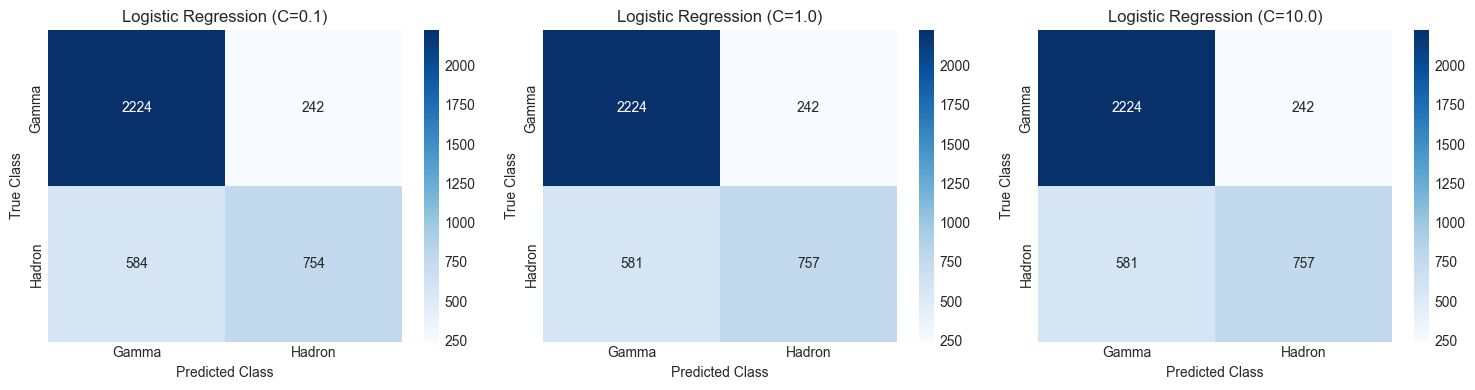

In [22]:
# Plot confusion matrices for all logistic regression models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, C in enumerate(C_values):
    y_pred = lr_models[C].predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Gamma', 'Hadron'], 
                yticklabels=['Gamma', 'Hadron'],
                ax=axes[idx])
    axes[idx].set_title(f'Logistic Regression (C={C})')
    axes[idx].set_xlabel('Predicted Class')
    axes[idx].set_ylabel('True Class')

plt.tight_layout()
plt.show()

### 6.3 Support Vector Machine

Support Vector Machine models are trained with three different kernel configurations: linear kernel (linear decision boundary), RBF kernel with C=1.0 (nonlinear with moderate regularization), and RBF kernel with C=10.0 (nonlinear with weak regularization). The RBF (Radial Basis Function) kernel allows the model to capture complex nonlinear patterns in the data.

In [23]:
from sklearn.svm import SVC

# Train SVM models with different configurations
svm_models = {}
svm_results = []

svm_configs = [
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'rbf', 'C': 1.0},
    {'kernel': 'rbf', 'C': 10.0}
]

for config in svm_configs:
    # Train model
    svm = SVC(**config, random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = svm.predict(X_test_scaled)
    
    # Calculate metrics (pos_label=1 for gamma rays)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store model and results
    config_name = f"{config['kernel']}_C{config['C']}"
    svm_models[config_name] = svm
    svm_results.append({
        'Kernel': config['kernel'],
        'C': config['C'],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"SVM ({config['kernel']} kernel, C={config['C']}):")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print()

# Create results dataframe
svm_results_df = pd.DataFrame(svm_results)
print("SVM Results Summary:")
print(svm_results_df.to_string(index=False))

SVM (linear kernel, C=1.0):
  Accuracy:  0.7797
  Precision: 0.7922
  Recall:    0.8950
  F1-Score:  0.8404

SVM (rbf kernel, C=1.0):
  Accuracy:  0.8686
  Precision: 0.8582
  Recall:    0.9550
  F1-Score:  0.9040

SVM (rbf kernel, C=10.0):
  Accuracy:  0.8759
  Precision: 0.8657
  Recall:    0.9570
  F1-Score:  0.9091

SVM Results Summary:
Kernel    C  Accuracy  Precision   Recall  F1-Score
linear  1.0  0.779706   0.792175 0.894972  0.840442
   rbf  1.0  0.868559   0.858236 0.954988  0.904031
   rbf 10.0  0.875920   0.865737 0.957015  0.909091


### 6.4 Support Vector Machine Confusion Matrices

The confusion matrices below show the classification performance for each SVM configuration. These matrices provide insight into how different kernel functions and regularization parameters affect the balance between gamma and hadron classification.

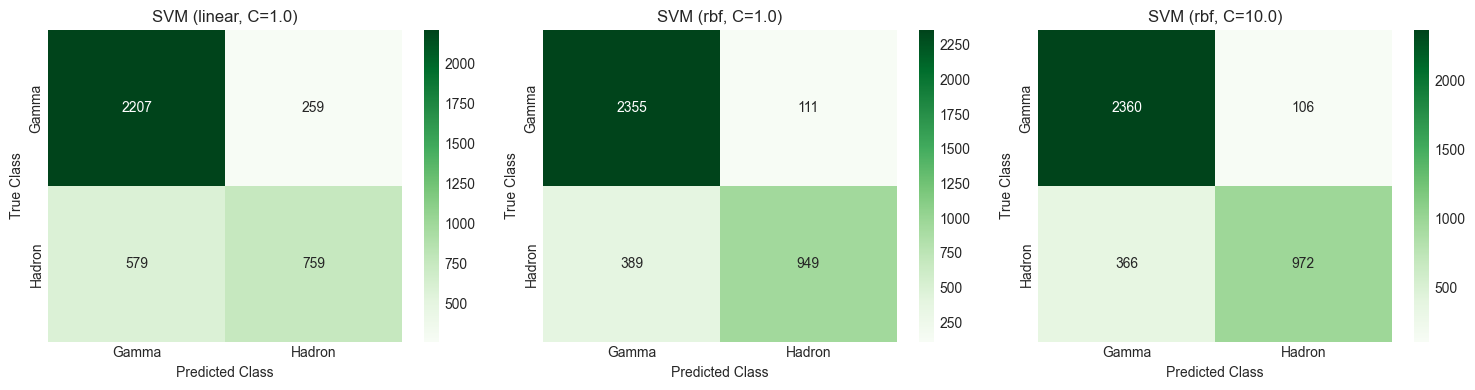

In [24]:
# Plot confusion matrices for all SVM models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, config in enumerate(svm_configs):
    config_name = f"{config['kernel']}_C{config['C']}"
    y_pred = svm_models[config_name].predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=['Gamma', 'Hadron'], 
                yticklabels=['Gamma', 'Hadron'],
                ax=axes[idx])
    axes[idx].set_title(f"SVM ({config['kernel']}, C={config['C']})")
    axes[idx].set_xlabel('Predicted Class')
    axes[idx].set_ylabel('True Class')

plt.tight_layout()
plt.show()

### 6.5 Classical ML Model Comparison

The table below summarizes the performance of all classical machine learning models trained in this section. This comparison reveals which algorithms and hyperparameter settings perform best on the gamma-hadron classification task.

In [25]:
# Combine all results for comparison
all_classical_results = []

# Add logistic regression results
for result in lr_results:
    all_classical_results.append({
        'Model': 'Logistic Regression',
        'Configuration': f"C={result['C']}",
        'Accuracy': result['Accuracy'],
        'Precision': result['Precision'],
        'Recall': result['Recall'],
        'F1-Score': result['F1-Score']
    })

# Add SVM results
for result in svm_results:
    all_classical_results.append({
        'Model': 'SVM',
        'Configuration': f"{result['Kernel']}, C={result['C']}",
        'Accuracy': result['Accuracy'],
        'Precision': result['Precision'],
        'Recall': result['Recall'],
        'F1-Score': result['F1-Score']
    })

# Create comparison dataframe
comparison_df = pd.DataFrame(all_classical_results)
print("Classical Machine Learning Models - Performance Comparison:")
print(comparison_df.to_string(index=False))

# Find best model by F1-score
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.iloc[best_model_idx]
print(f"\nBest performing model: {best_model['Model']} ({best_model['Configuration']})")
print(f"F1-Score: {best_model['F1-Score']:.4f}")

Classical Machine Learning Models - Performance Comparison:
              Model Configuration  Accuracy  Precision   Recall  F1-Score
Logistic Regression         C=0.1  0.782860   0.792023 0.901865  0.843383
Logistic Regression         C=1.0  0.783649   0.792870 0.901865  0.843863
Logistic Regression        C=10.0  0.783649   0.792870 0.901865  0.843863
                SVM linear, C=1.0  0.779706   0.792175 0.894972  0.840442
                SVM    rbf, C=1.0  0.868559   0.858236 0.954988  0.904031
                SVM   rbf, C=10.0  0.875920   0.865737 0.957015  0.909091

Best performing model: SVM (rbf, C=10.0)
F1-Score: 0.9091


## References

Albert, J., Aliu, E., Anderhub, H., Antoranz, P., Armada, A., Asensio, M., ... & Baixeras, C. (2008). Implementation of the random forest method for the imaging atmospheric Cherenkov telescope MAGIC. Nuclear Instruments and Methods in Physics Research Section A, 588(3), 424-432.

Bock, R. K. (2007). MAGIC Gamma Telescope Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C52C8B

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press. http://www.deeplearningbook.org

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction (2nd ed.). Springer.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.